In [1]:
from __future__ import print_function
from pixell import enmap,utils, reproject, enplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os,sys
import urllib.request
from scipy import interpolate
from astropy.table import QTable
import astropy.units as u
from astropy.io import fits
import csv
import yaml
from scipy.stats import norm
import matplotlib.patheffects as path_effects
import pickle as pk
from matplotlib.ticker import Locator
%matplotlib inline

In [2]:
forced_phot_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/MADCOWSUnion_M500.fits')
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

#Rescale to account for miscentering
rescale = 1.25

names = forced_phot_catalog[1].data['name']
yc = forced_phot_catalog[1].data['y_c']
yc_err =forced_phot_catalog[1].data['err_y_c']

mdcw_names = mdcw_catalog[1].data['name']
mdcw_rich = mdcw_catalog[1].data['rich']
mdcw_rich_err = mdcw_catalog[1].data['e_rich']

rich = []
rich_err = []

point_sources = ['MOO J0015+0801', 'MOO J0208-2951', 'MOO J0306+0857', 'MOO J0917+1456', 'MOO J0936+0336', 'MOO J1355-0114', 'MOO J2247+0507', 'MOO J1247+1426']

for i in range(len(names)):
    #if names[i] in point_sources:
    #    print('Skip')
    #    continue
    idx = np.where((names[i] == mdcw_names))[0]
    rich.append(int(mdcw_rich[idx]))
    rich_err.append(int(mdcw_rich_err[idx]))


flag = np.where((np.array(rich) != 999999) & (np.array(rich) != 0))[0]
yc, yc_err, rich, rich_err = np.array(yc)[flag], np.array(yc_err)[flag], np.array(rich)[flag], np.array(rich_err)[flag]
#flag = np.where((np.abs(yc_err)<1))[0]
#yc, yc_err, rich, rich_err = np.array(yc)[flag], np.array(yc_err)[flag], np.array(rich)[flag], np.array(rich_err)[flag]



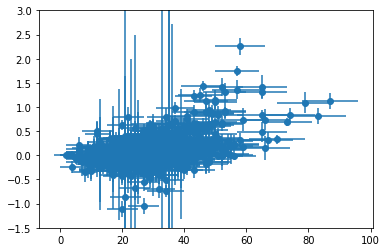

In [4]:
plt.errorbar(rich, yc, xerr=rich_err, yerr = yc_err, fmt = 'o', linestyle = 'none')
#plt.scatter(rich, yc_err)
plt.ylim(-1.5,3)
plt.show()

In [26]:
yc, yc_err = yc*rescale, yc_err*rescale

In [70]:
catalog = {'yc' : [], 'yc_err' : []}

yc, yc_err = yc*rescale, yc_err*rescale

num_boot = 1000

for i in range(num_boot):
    bin_yc = []
    bin_yc_err = []
    for j in range(20,70, 10):

        flag = np.where((rich>j) & (rich<=j+10))[0]
        if len(flag) == 0: continue

        yc_temp, yc_err_temp = yc[flag], yc_err[flag]
        
        flags = np.random.randint(len(yc_temp), size = len(yc_temp))
        
        yc_temp2, yc_err_temp2 = yc_temp[flags], yc_err_temp[flags]

        denominator = 0
        for i in range(len(yc_err_temp)):
            denominator += 1/yc_err_temp[i]

        numerator = 0
        for i in range(len(yc_temp2)):
            numerator += (yc_temp2[i]-np.average(yc_temp2))**2

        bin_yc.append(np.average(yc_temp2))
        bin_yc_err.append(np.sqrt(numerator)/len(yc_temp2))

    catalog['yc'].append(bin_yc)
    catalog['yc_err'].append(bin_yc_err)

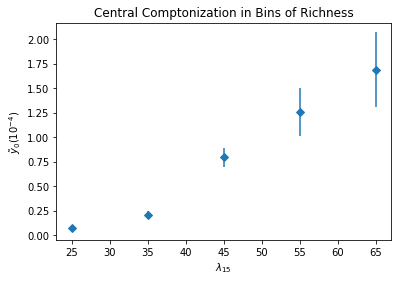

In [71]:
xrange = range(25,75,10)
plt.errorbar(xrange, np.average(catalog['yc'], axis = 0), np.std(catalog['yc'], axis = 0), fmt = 'D', linestyle = 'none')
#plt.plot(xrange,bin_yc)
plt.xlabel('$\lambda_{15}$')
plt.ylabel(r'$\tilde{y}_0 (10^{-4})$')
plt.title('Central Comptonization in Bins of Richness')
plt.savefig('./plots/forced_photometry/mdcw_bin_forced_photometry.pdf')
plt.savefig('./plots/forced_photometry/mdcw_bin_forced_photometry.png', dpi = 300)
plt.show()
plt.close()

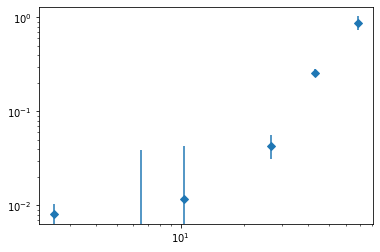

In [57]:
numBins=8
log10Rich=np.log10(rich)
binEdges=np.linspace(log10Rich.min(), log10Rich.max(), numBins+1)
binCenters=(binEdges[1:]+binEdges[:-1])/2.
mean_y=np.zeros(len(binCenters))
err_y=np.zeros(len(binCenters))

num_boot = 1000

for i in range(len(binCenters)):
    binMin=binEdges[i]
    binMax=binEdges[i+1]
    mask=np.logical_and(log10Rich >= binMin, log10Rich < binMax)
    yvals=yc[mask]*rescale
    mean_y[i]=np.mean(yvals)
    bsMeans=[]
    for j in range(num_boot):
        bsIndices=np.random.randint(0, len(yvals), len(yvals))
        bsMeans.append(np.mean(yvals[bsIndices]))
    err_y[i]=np.std(bsMeans)

plt.xscale('log')
plt.yscale('log')
plt.errorbar(np.power(10, binCenters), mean_y, yerr = err_y,fmt = 'D')
plt.savefig('./plots/forced_photometry/log_mdcw_bin_forced_photometry_no_ps.pdf')
plt.savefig('./plots/forced_photometry/log_mdcw_bin_forced_photometry_no_ps.png', dpi = 300)
plt.show()

(array([  5.,  34., 715., 621.,  87.,  28.,  13.,   3.,   2.,   1.]),
 array([-6.6931335 , -4.37716998, -2.06120647,  0.25475705,  2.57072057,
         4.88668409,  7.2026476 ,  9.51861112, 11.83457464, 14.15053815,
        16.46650167]),
 <a list of 10 Patch objects>)

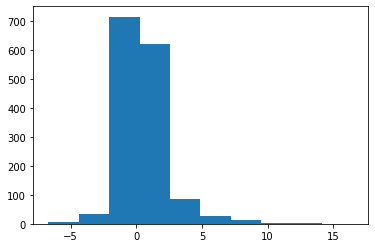

In [9]:
forced_phot_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/MADCOWSUnion_M500.fits')
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

names = forced_phot_catalog[1].data['name']
yc = forced_phot_catalog[1].data['y_c']
yc_err =forced_phot_catalog[1].data['err_y_c']

m500 = forced_phot_catalog[1].data['M500']
m500Plus = forced_phot_catalog[1].data['M500_errPlus']
m500Minus = forced_phot_catalog[1].data['M500_errMinus']

snr = forced_phot_catalog[1].data['SNR']

plt.hist(snr)

In [10]:
snr_cut = snr[3<snr]
snr_cut = snr_cut[4>snr_cut]
print(len(snr_cut))

35


In [12]:
#for i in range(750, 775):
#    print(names[i])
#    print('M500 = {:.2f} + {:.2f} - {:.2f}'.format(m500[i], m500Plus[i], m500Minus[i]))
    
#flag = np.where((str(names) == 'MOO J1345-0125'))
#print(flag)

#sched_A = ['MOO J1330+2157', 'MOO J1001+6619', 'MOO J1139-1706', 'MOO J1346-0142', 'MOO J1554-0447', 'MOO J1337+3529', 'MOO J1514+1346', 'MOO J2216+1738', 'MOO J1635+2452']

for i in range(len(names)):
    if names[i] == 'MOO J2207+0757':
    #if names[i] in sched_A:
        print(names[i])
        print('M500 = {:.2f} + {:.2f} - {:.2f}'.format(m500[i], m500Plus[i], m500Minus[i]))
        print('SNR = {:.2f}'.format(snr[i]))

MOO J2207+0757
M500 = 0.27 + 0.19 - 0.11
SNR = 0.87


In [3]:
forced_90 = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/S18d_202006_forcedMaDCoWS_f090Only_optimalCatalog.fits')
forced_150 = fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/S18d_202006_forcedMaDCoWS_f150Only_optimalCatalog.fits')

mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')


In [27]:
print(forced_90[1].header)
i = 100
print(forced_90[1].data[i]['fixed_y_c']/forced_90[1].data[i]['y_c     '])
#print(forced_150[1].header)
print(forced_150[1].data[i]['fixed_y_c']/forced_150[1].data[i]['y_c     '])

print(forced_150[1].data[i]['fixed_y_c']/forced_90[1].data[i]['fixed_y_c'])

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  151 / length of dimension 1                          NAXIS2  =                 1508 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                   18 / number of table fields                         TTYPE1  = 'name    '                                                            TFORM1  = '14A     '                                                            TTYPE2  = 'RADeg   '                                                            TFORM2  = 'D       '                                                            TTYPE3  = 'decDeg  '                    

In [36]:
forced_phot_catalog = fits.open('MADCOWSUnion_mass_v1.0.fits')
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

forced_names = forced_phot_catalog[1].data['name']
forced_masses = forced_phot_catalog[1].data['M500cUncorr']
mdcw_names = mdcw_catalog[1].data['name']
mdcw_rich = mdcw_catalog[1].data['rich']

In [37]:
flags = np.where((mdcw_rich>20) & (mdcw_rich<1000))[0]

In [38]:
print(len(flags))

1489


In [39]:
names = mdcw_names[flags]

In [40]:
print(forced_phot_catalog[1].header)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  286 / length of dimension 1                          NAXIS2  =                 1509 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                   34 / number of table fields                         TTYPE1  = 'name    '                                                            TFORM1  = '14A     '                                                            TTYPE2  = 'RADeg   '                                                            TFORM2  = 'D       '                                                            TTYPE3  = 'decDeg  '                    

In [47]:
masses = []
for i, name in enumerate(forced_names):
    if name in names and forced_masses[i]>0:
        masses.append(forced_masses[i]*1.25)

In [48]:
print(np.mean(masses))

1.4709964696711029
